In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Using Theano backend.


In [10]:
# Load the data in from the serialized array
# Font data is sorted in 4D arrays of shape (770, 1, 60, 1300)
x_data = np.load(file='test_font_arr.npy')
y_data = np.load(file='font_arr.npy')

x_train = x_data[:len(x_data) * 0.8]
x_test = x_data[len(x_data) * 0.8:]

y_train = y_data[:len(y_data) * 0.8]
y_test = y_data[len(y_data) * 0.8:]


/home/david/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/david/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/david/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/david/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


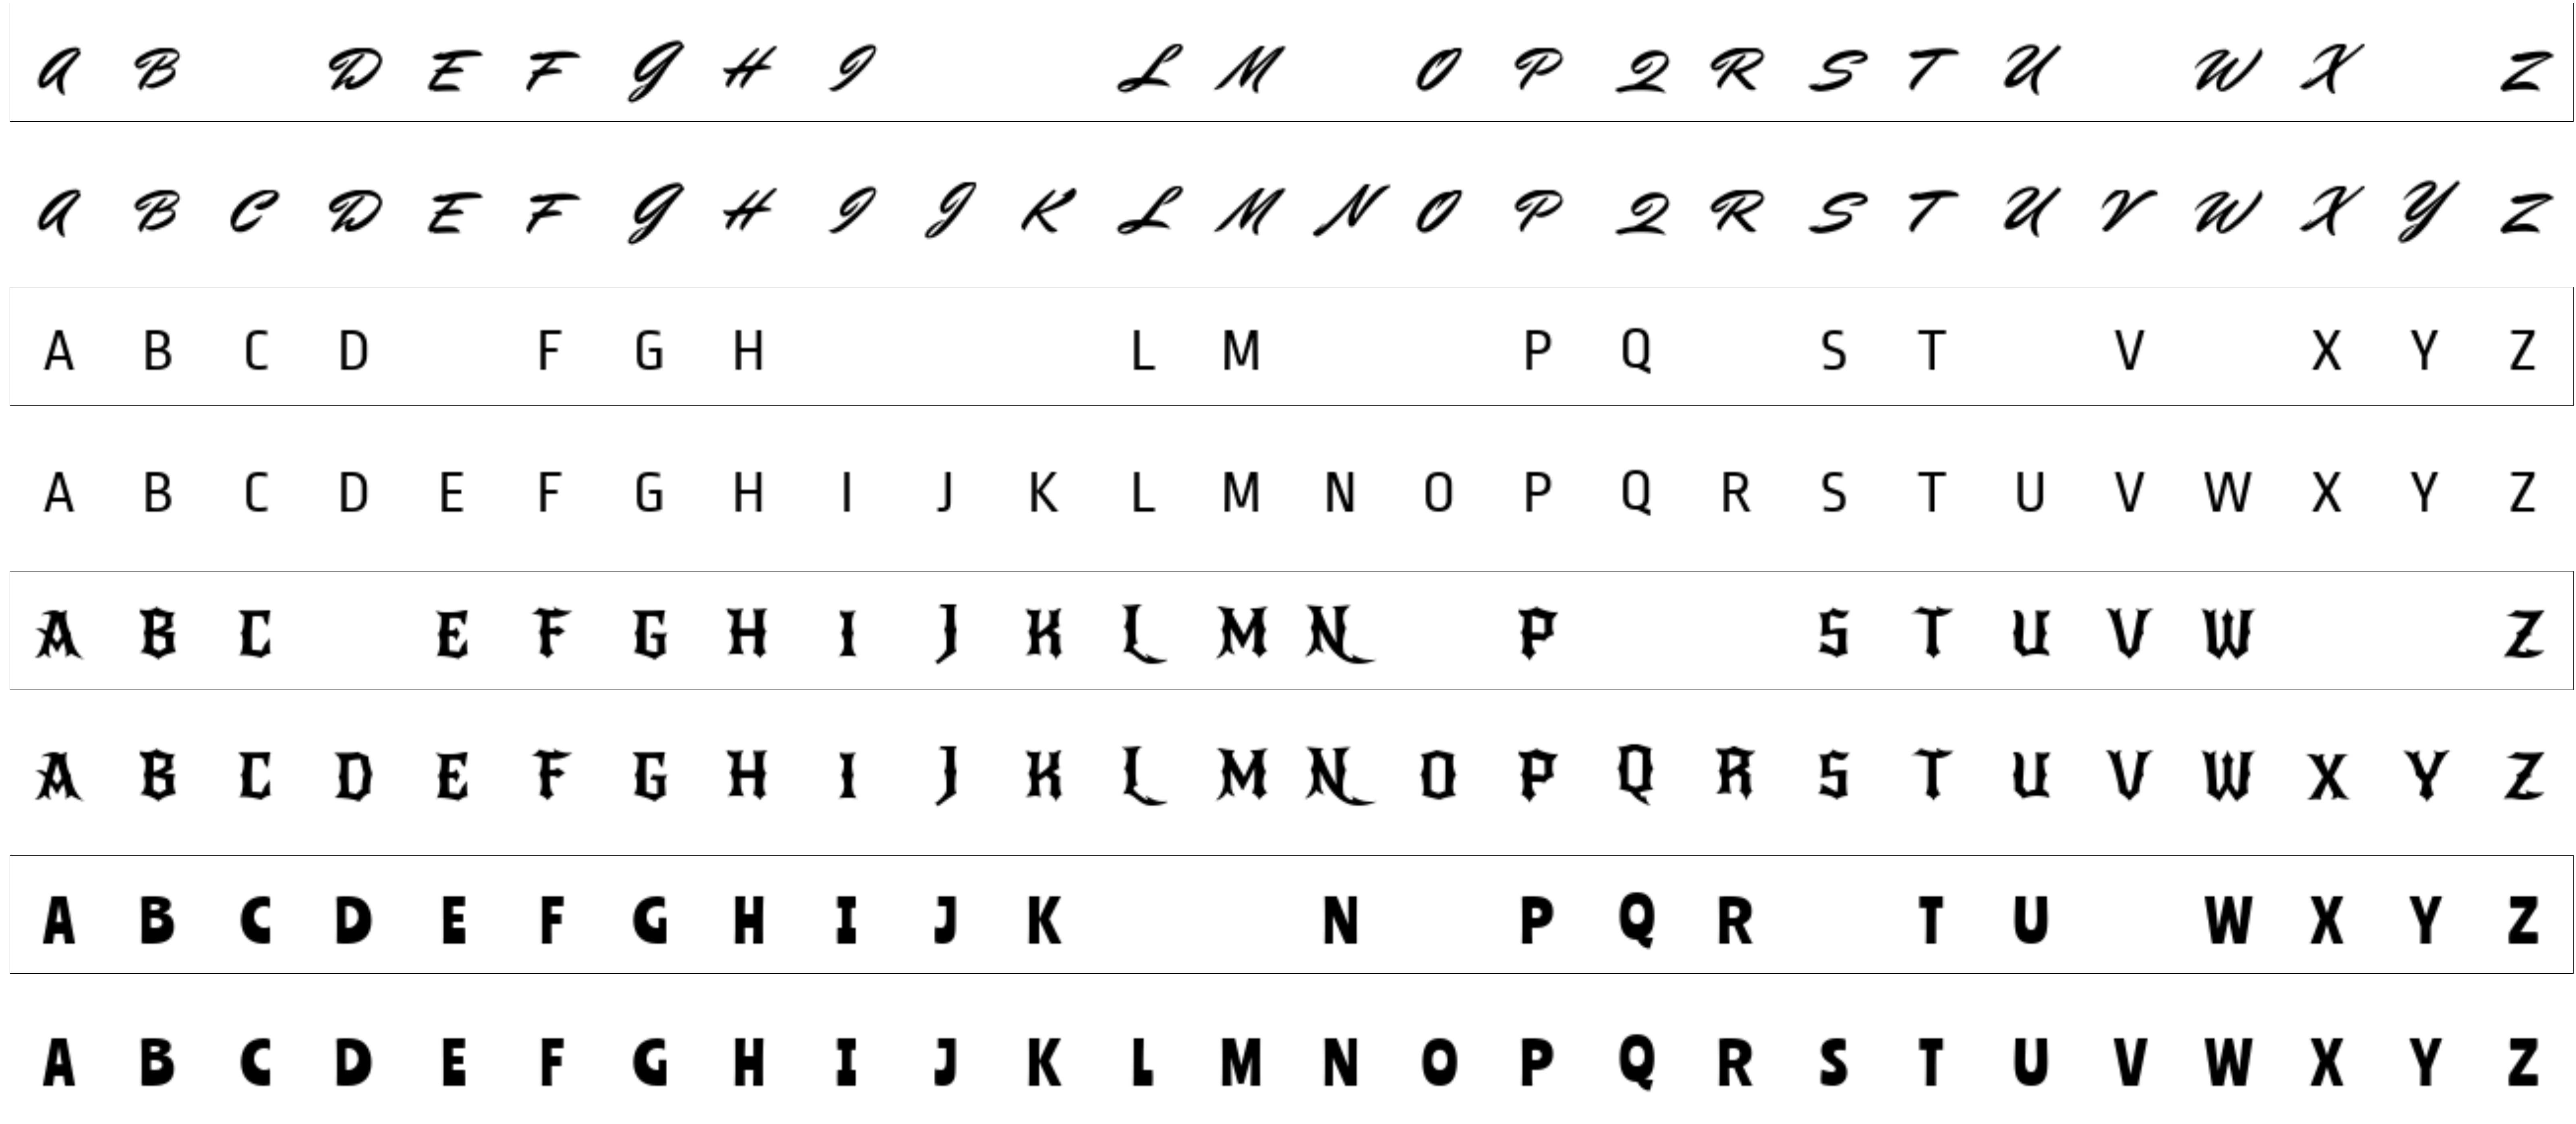

In [28]:
n = 4
plt.figure(figsize=(120, 100))
cnt = 1
for i in range(1,n+1):  
    # display input
    ax = plt.subplot(n*4, 1, cnt)
    plt.imshow(x_test[i].reshape(60, 1300))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    cnt+=1
    
    # display desired output
    ax = plt.subplot(n*4, 1, cnt).axis('off')
    plt.imshow(y_test[i].reshape(60, 1300))
    plt.gray()
    cnt+=1
plt.show()

In [29]:
# Runs 32 different kernels through the image
num_filters = 32

# 3x3 kernel size
kernel_x = 54
kernel_y = 5

# Downscale the image by a factor of 2 each pooling layer
pooling_factors = (2,2)

In [30]:
input_img = Input(shape=(1, 60, 1300), name='Input image')

x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Encoding conv #1')(input_img)
x = MaxPooling2D(pooling_factors, border_mode='same', name='Pooling layer #1')(x)
x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Encoding conv #2')(x)
encoded = MaxPooling2D(pooling_factors, border_mode='same', name='Encoding pooling layer')(x)

# at this point the representation is (32, 7, 7)
# EACH FILTER ADDS A DIMENSION!!!!

x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Decoding conv #1')(encoded)
x = UpSampling2D(pooling_factors, name='Upsampling layer #1')(x)
x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Decoding conv #2')(x)
x = UpSampling2D(pooling_factors, name='Upsampling layer #2')(x)
decoded = Convolution2D(1, kernel_x, kernel_y, activation='sigmoid', border_mode='same', name='Piece-together conv layer')(x)
# THE NUMBER OF KERNELS HERE IS 1 BECAUSE THAT WAY IT OUTPUTS A SINGLE DIMENSION (CHANNEL)

# Compiles the model diagram described above into a neural network
autoencoder = Model(input=input_img, output=decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [34]:
# How many training cycles the program does
num_epoch = 1

# How many images to process before backpropagating
batch_size = 4

In [35]:
print('Batch size:', batch_size,'\nNumber of epochs:', num_epoch)
train = autoencoder.fit(x_train, y_train,
                nb_epoch=num_epoch,
                batch_size=batch_size,
                validation_data=(x_test, y_test))


Batch size: 4 
Number of epochs: 1
Train on 615 samples, validate on 154 samples
Epoch 1/1
615/615 [==============================] - 201s - loss: 0.0774 - val_loss: 0.0782


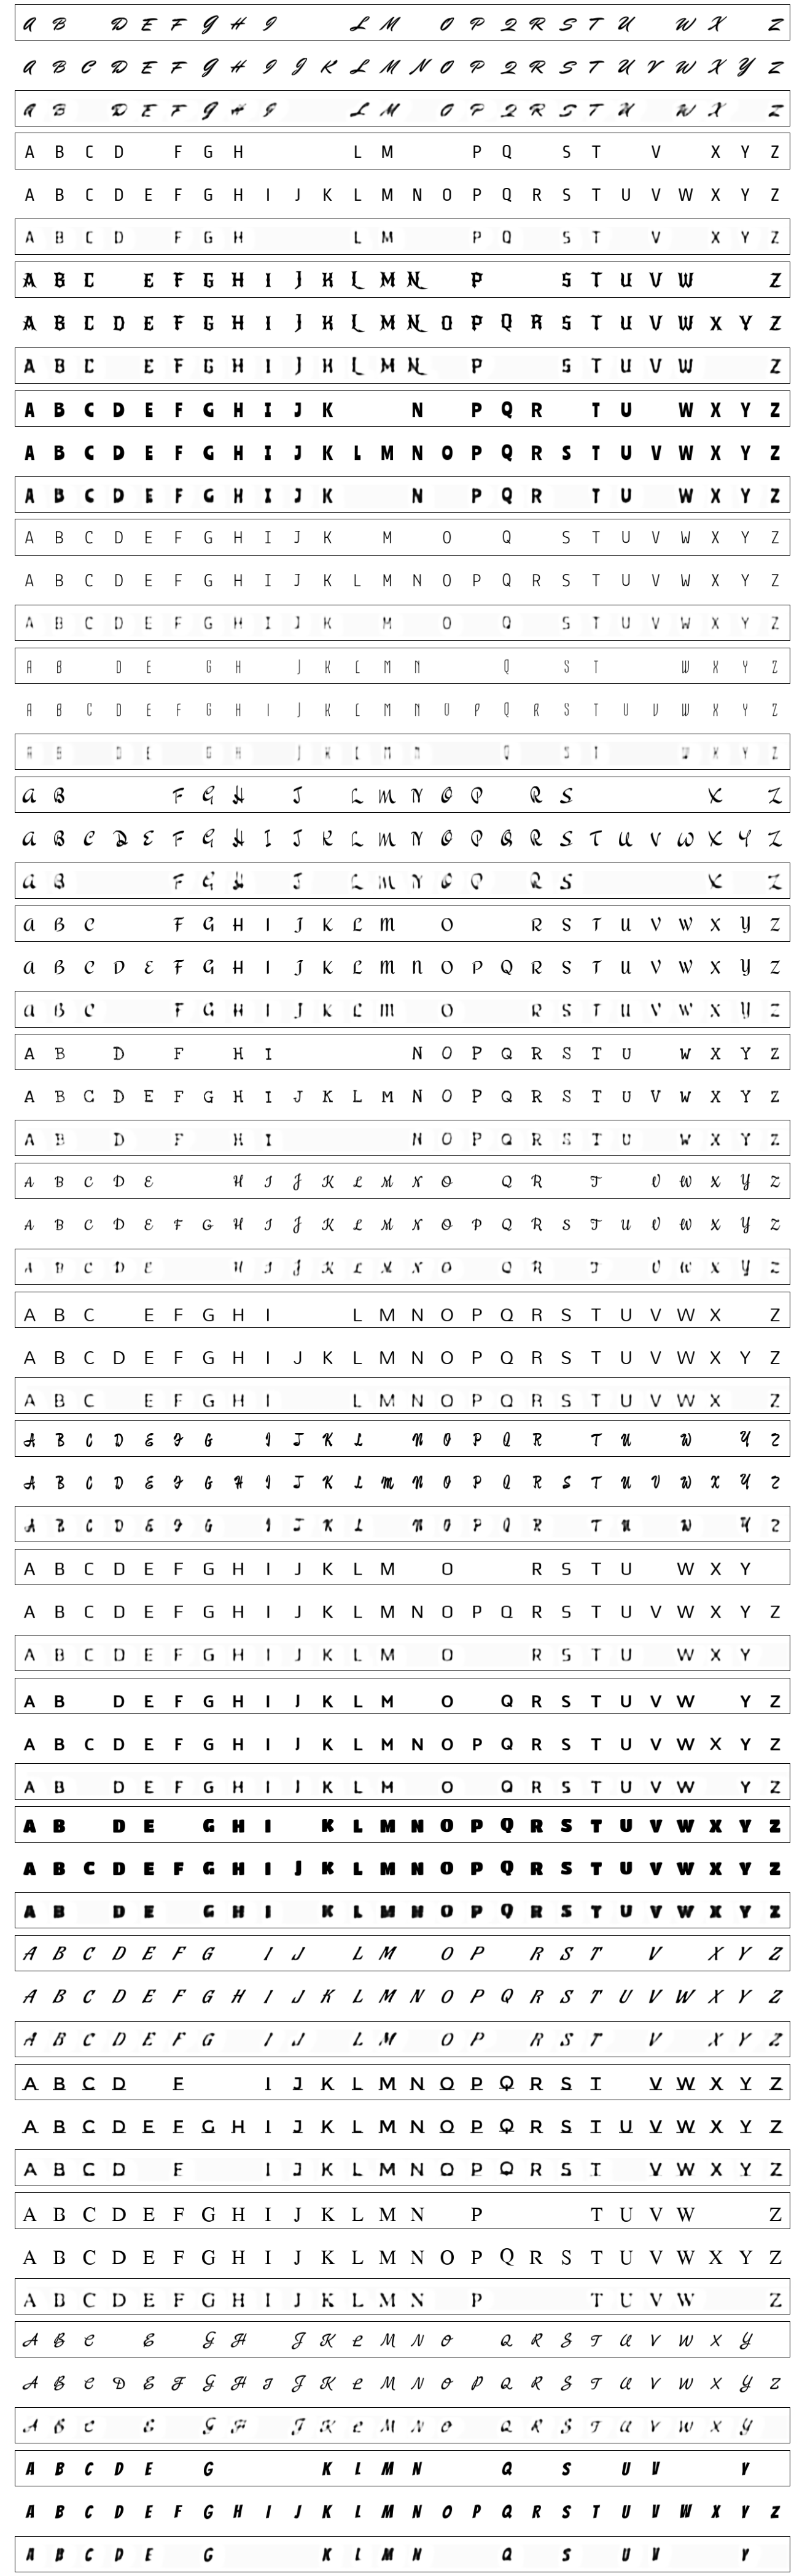

In [36]:
n = 5
decoded_imgs = autoencoder.predict(x_test[:n+1])
plt.figure(figsize=(120, 100))
cnt = 1
for i in range(1,n+1):
    # display input
    ax = plt.subplot(n*4, 1, cnt)
    plt.imshow(x_test[i].reshape(60, 1300))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    cnt+=1
    
    # display original
    ax = plt.subplot(n*4, 1, cnt).axis('off')
    plt.imshow(y_test[i].reshape(60, 1300))
    plt.gray()
    cnt+=1

    # display reconstruction
    ax = plt.subplot(n*4, 1, cnt)
    plt.imshow(decoded_imgs[i].reshape(60, 1300))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    cnt+=1
plt.show()

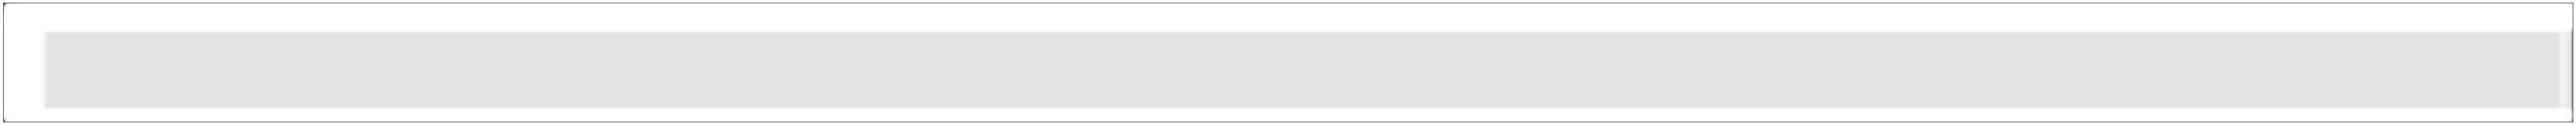

In [37]:
n = 1
blank = np.full(shape=(1, 1, 60, 1300), fill_value=1.0)
decoded_imgs = autoencoder.predict(blank)
plt.figure(figsize=(100, 40))

ax = plt.subplot(1, 1, 1)
plt.imshow(decoded_imgs[0].reshape(60, 1300))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
from IPython.display import SVG, Image
from keras.utils.visualize_util import model_to_dot, plot

# SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))
plot(autoencoder, to_file='autoencoder.png', show_shapes=True)
Image(filename="autoencoder.png")